In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import bambi as bmb
import os

In [20]:
# data = pd.read_csv('data/')
sns.set_context('talk')
sns.set_style('darkgrid')

In [7]:
# list(data.columns)

In [8]:
def clean_data(parent_folder, filename):
    data = pd.read_csv(f'{parent_folder}/{filename}')
    graph_type = data['graph_type'][0]
    if 'walk_length' in list(data.columns):
        walk_length = data['walk_length'].unique()[0]
        if walk_length == 1000:
            walk_length = 300
    else:
        walk_length = 300
    cleaned_cat_data = data[['Prolific ID', 'test_index', 'num_feats', 'Correct Response', 'test_key_resp.corr', 'test_key_resp.rt', 'test_key_resp.keys']].dropna().reset_index(drop=True)
    cleaned_cat_data['graph_type'] = graph_type
    return cleaned_cat_data

In [10]:
filenames = [] 
for f in os.listdir('eb_cat1_order_eqfeat/catA_data'):
    if f.startswith('undefined') and f.endswith('csv'):
        filenames.append(f)
df_clean_catA = pd.concat([clean_data('eb_cat1_order_eqfeat/catA_data', f) for f in filenames])
df_clean_catA['dims'] = 'odd'
df_clean_participant_catA = df_clean_catA.groupby(by = ['Prolific ID', 'num_feats', 'graph_type', 'dims']).mean(numeric_only=True).reset_index()

filenames = [] 
for f in os.listdir('eb_cat1_order_eqfeat/catB_data'):
    if f.startswith('undefined') and f.endswith('csv'):
        filenames.append(f)
df_clean_catB = pd.concat([clean_data('eb_cat1_order_eqfeat/catB_data', f) for f in filenames])
df_clean_catB['dims'] = 'even'
df_clean_participant_catB = df_clean_catB.groupby(by = ['Prolific ID', 'num_feats', 'graph_type', 'dims']).mean(numeric_only=True).reset_index()

df_clean = pd.concat([df_clean_catA, df_clean_catB]).reset_index(drop=True)
df_clean.to_csv('df_clean_exp5.csv')
df_clean_participant = pd.concat([df_clean_participant_catA, df_clean_participant_catB]).reset_index(drop=True)


In [14]:
df_clean['category'] = 'A'
df_clean.loc[df_clean.dims == 'even', 'category'] = 'B'

In [18]:
df_clean.groupby(['category', 'num_feats']).describe().iloc[:, -15:-13].to_latex('tables/exp5_accuracy_stats.txt', float_format="%.3f")

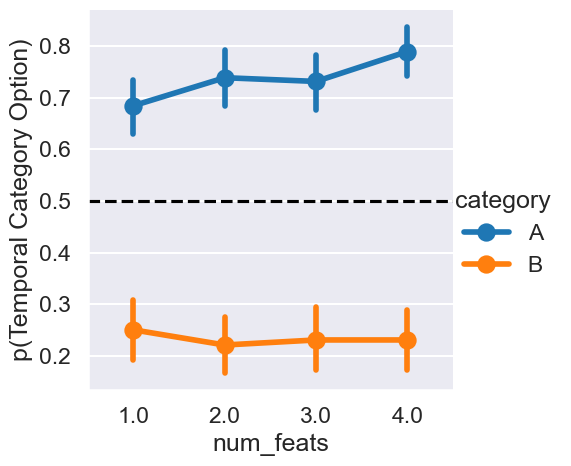

In [21]:
g = sns.catplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean, kind = 'point', hue = 'category')
g.axes[0][0].axhline(y = 0.5, ls = '--', color = 'black')
g.axes[0][0].set_ylabel('p(Temporal Category Option)')
plt.savefig('figures/exp5_proportion_results.png', dpi = 300, transparent = True)


In [54]:
df_clean['participant'] = df_clean['Prolific ID']
bmb_model = bmb.Model('test_key_resp.corr ~ (0  + C(num_feats)|category) + (1|participant)', data = df_clean, family='bernoulli')



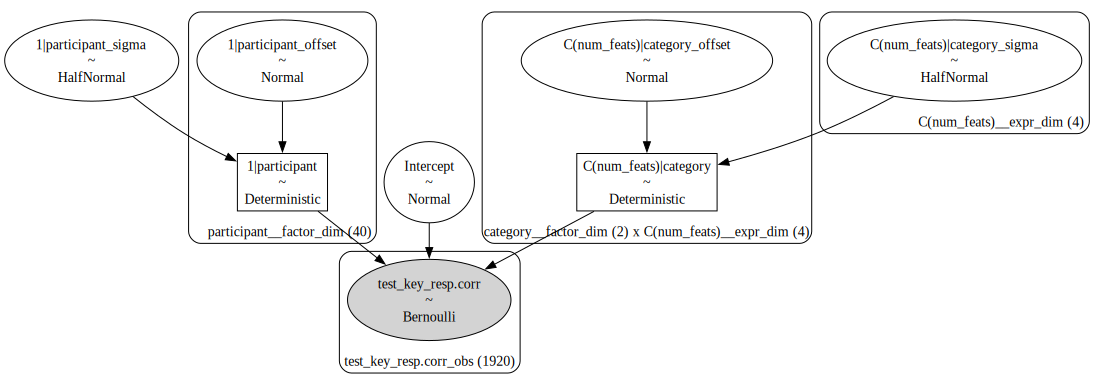

In [55]:
bmb_model.build()
bmb_model.graph()

In [56]:
samples = bmb_model.fit()

Modeling the probability that test_key_resp.corr==1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(num_feats)|category_sigma, C(num_feats)|category_offset, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 323 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


In [73]:
bmb_model

       Formula: test_key_resp.corr ~ (0  + C(num_feats)|category) + (1|participant)
        Family: bernoulli
          Link: p = logit
  Observations: 1920
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            C(num_feats)|category ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: [5.7735 5.7735 5.7735 5.7735]))
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [57]:
az.summary(samples, var_names="category", filter_vars="like").iloc[:, :4]#.to_latex('tables/exp5_bayesmodel_results.txt', float_format="%.3f")

,mean,sd,hdi_3%,hdi_97%
"C(num_feats)|category[1.0, A]",1.008,0.756,-0.313,2.527
"C(num_feats)|category[1.0, B]",-1.155,0.760,-2.572,0.212
"C(num_feats)|category[2.0, A]",1.338,0.761,0.064,2.866
"C(num_feats)|category[2.0, B]",-1.420,0.761,-2.874,-0.043
"C(num_feats)|category[3.0, A]",1.299,0.761,-0.127,2.735
"C(num_feats)|category[3.0, B]",-1.331,0.759,-2.736,0.111
"C(num_feats)|category[4.0, A]",1.689,0.765,0.392,3.258
"C(num_feats)|category[4.0, B]",-1.332,0.754,-2.770,0.056
C(num_feats)|category_sigma[1.0],2.725,2.144,0.375,7.116
C(num_feats)|category_sigma[2.0],2.844,1.852,0.484,6.588


In [59]:
az.extract(samples, var_names="category", filter_vars="like")

<xarray.Dataset> Size: 448kB
Dimensions:                      (C(num_feats)__expr_dim: 4,
                                  category__factor_dim: 2, sample: 4000)
Coordinates:
  * category__factor_dim         (category__factor_dim) <U1 8B 'A' 'B'
  * C(num_feats)__expr_dim       (C(num_feats)__expr_dim) <U3 48B '1.0' ... '...
  * sample                       (sample) object 32kB MultiIndex
  * chain                        (sample) int32 16kB 0 0 0 0 0 0 ... 3 3 3 3 3 3
  * draw                         (sample) int32 16kB 0 1 2 3 ... 996 997 998 999
Data variables:
    C(num_feats)|category        (C(num_feats)__expr_dim, category__factor_dim, sample) float64 256kB ...
    C(num_feats)|category_sigma  (C(num_feats)__expr_dim, sample) float64 128kB ...
Attributes:
    created_at:                  2024-07-30T02:31:39.947733+00:00
    arviz_version:               0.18.0
    inference_library:           pymc
    inference_library_version:   5.16.2
    sampling_time:               323.13707733154297
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

In [62]:
extracted.sel({'category__factor_dim' :'A', "C(num_feats)__expr_dim": f'{num_feats}'})

<xarray.DataArray 'C(num_feats)|category' (sample: 4000)> Size: 32kB
array([ 1.30166471,  1.12573434,  1.04379136, ...,  1.47388653,
        0.8097912 , -0.24115418])
Coordinates:
    category__factor_dim    <U1 4B 'A'
    C(num_feats)__expr_dim  <U3 12B '1.0'
  * sample                  (sample) object 32kB MultiIndex
  * chain                   (sample) int32 16kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                    (sample) int32 16kB 0 1 2 3 4 ... 996 997 998 999

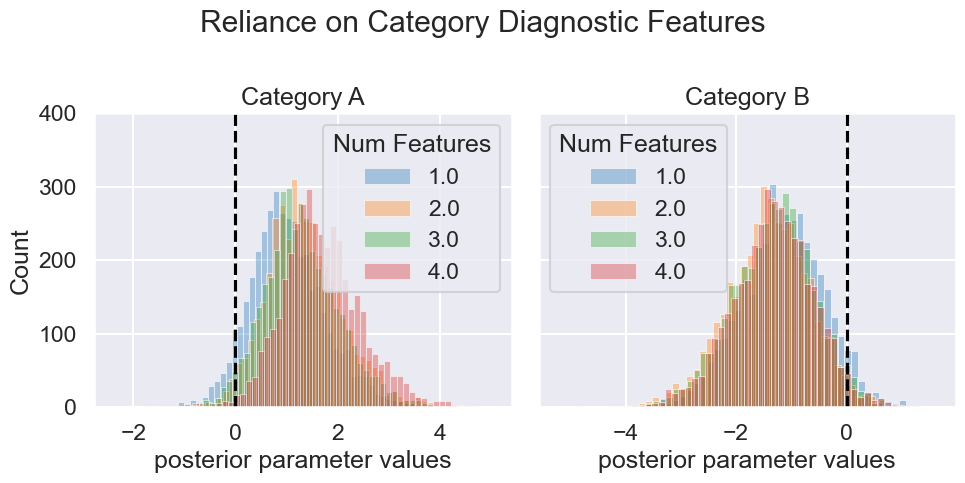

In [72]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
extracted = az.extract(samples, var_names="category", filter_vars="like")
for i, num_feats in enumerate(['1.0', '2.0', '3.0', '4.0']):
    sns.histplot(extracted.sel({'category__factor_dim' :'A', "C(num_feats)__expr_dim": f'{num_feats}'})['C(num_feats)|category'], alpha = 0.35, label = f"{num_feats}", ax = ax[0])
    sns.histplot(extracted.sel({'category__factor_dim' :'B', "C(num_feats)__expr_dim": f'{num_feats}'})['C(num_feats)|category'], alpha = 0.35, label = f"{num_feats}", ax = ax[1])
    # ge0 = np.mean(extracted.sel({'C(num_feats):category_dim' :f'{num_feats}, A'}) - extracted.sel({'C(num_feats):category_dim' :f'{num_feats}, B'}) > 0).values
    # plt.text(x = i*0.1, y = 300 - i*40, s = f"{round(ge0*100, 2)}%", color = f"C{i}", fontweight = "heavy")

# plt.xlim((-1.5, 2))
# plt.xticks(ticks = [], labels=[])
# plt.title('Category A - Category B exposure \n Relative Probability of relying on \n Category diagnostic features')
ax[0].set_title('Category A')
ax[0].axvline(x = 0, ls = '--', color = 'black')
ax[0].set_ylim((0, 400))
ax[0].legend(loc='best', title = "Num Features")#, bbox_to_anchor = (1.25, 0.5))
ax[0].set_xlabel('posterior parameter values')


ax[1].set_title('Category B')
ax[1].axvline(x = 0, ls = '--', color = 'black')
ax[1].set_ylim((0, 400))
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('posterior parameter values')
ax[1].legend(loc='best', title = "Num Features")#, bbox_to_anchor = (1.25, 0.5))
plt.suptitle('Reliance on Category Diagnostic Features')
fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('figures/exp5_bayesmodel_res.png', dpi = 300, transparent = True)#, bbox_inches = 'tight')

Text(0, 0.5, 'Categorization based on less frequent changes')

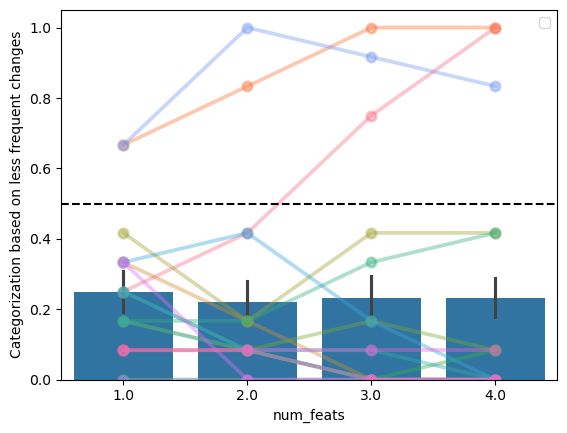

In [79]:
ax = sns.barplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_catB)
# sns.stripplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_participant, ax = ax)

sns.pointplot(x = 'num_feats', y = 'test_key_resp.corr',  hue = 'Prolific ID', data = df_clean_participant_catB, ax = ax, alpha = 0.4)
ax.legend('')
ax.axhline(y = 0.5, ls = '--', color = 'black')
ax.set_ylabel('Categorization based on less frequent changes')

Text(0, 0.5, 'Categorization based on less frequent changes')

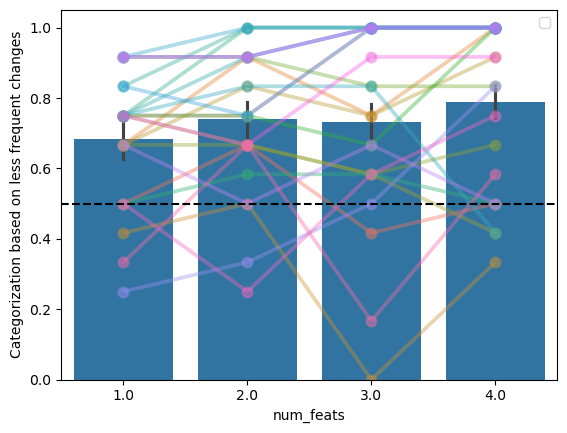

In [81]:
ax = sns.barplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_catA)
# sns.stripplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_participant, ax = ax)

sns.pointplot(x = 'num_feats', y = 'test_key_resp.corr',  hue = 'Prolific ID', data = df_clean_participant_catA, ax = ax, alpha = 0.4)
ax.legend('')
ax.axhline(y = 0.5, ls = '--', color = 'black')
ax.set_ylabel('Categorization based on less frequent changes')

Text(0, 0.5, 'Categorization based on less frequent changes')

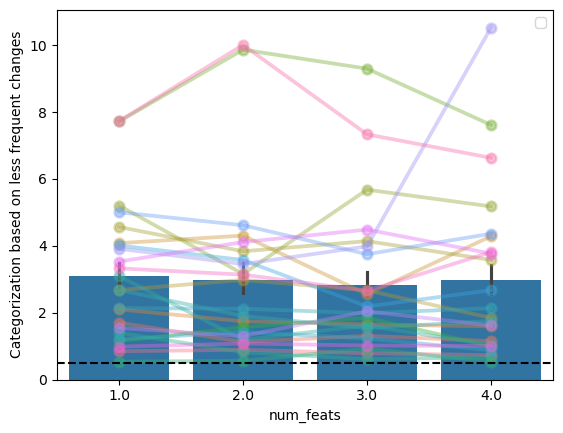

In [82]:
ax = sns.barplot(x = 'num_feats', y = 'test_key_resp.rt', data = df_clean_catA)
# sns.stripplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_participant, ax = ax)

sns.pointplot(x = 'num_feats', y = 'test_key_resp.rt',  hue = 'Prolific ID', data = df_clean_participant_catA, ax = ax, alpha = 0.4)
ax.legend('')
ax.axhline(y = 0.5, ls = '--', color = 'black')
ax.set_ylabel('Categorization based on less frequent changes')

Text(0, 0.5, 'Categorization based on less frequent changes')

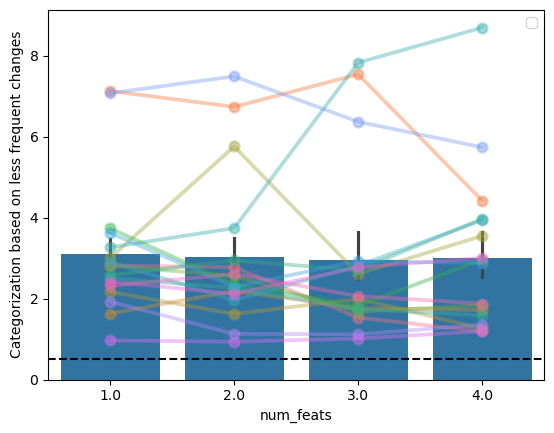

In [80]:
ax = sns.barplot(x = 'num_feats', y = 'test_key_resp.rt', data = df_clean_catB)
# sns.stripplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean_participant, ax = ax)

sns.pointplot(x = 'num_feats', y = 'test_key_resp.rt',  hue = 'Prolific ID', data = df_clean_participant_catB, ax = ax, alpha = 0.4)
ax.legend('')
ax.axhline(y = 0.5, ls = '--', color = 'black')
ax.set_ylabel('Categorization based on less frequent changes')

Text(41.698843846450615, 0.5, 'Proportion of Temporal Category Option Chosen')

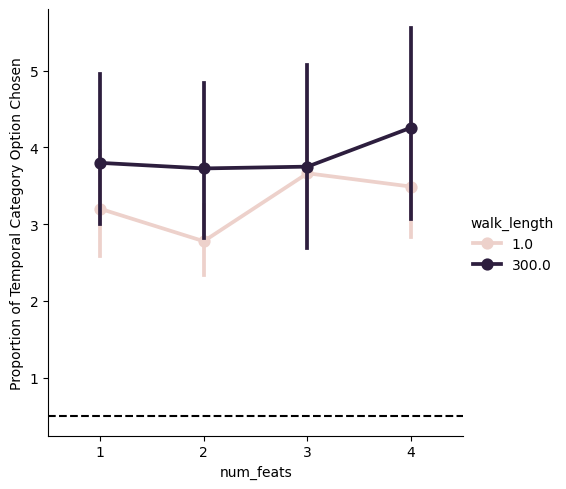

In [69]:
g = sns.catplot(x = 'num_feats', y = 'test_key_resp.rt', data = df_clean, kind = 'point', hue = 'walk_length')
g.axes[0][0].axhline(y = 0.5, ls = '--', color = 'black')
g.axes[0][0].set_ylabel('Proportion of Temporal Category Option Chosen')


Text(30.816589506172832, 0.5, 'Proportion of Temporal Category Option Chosen')

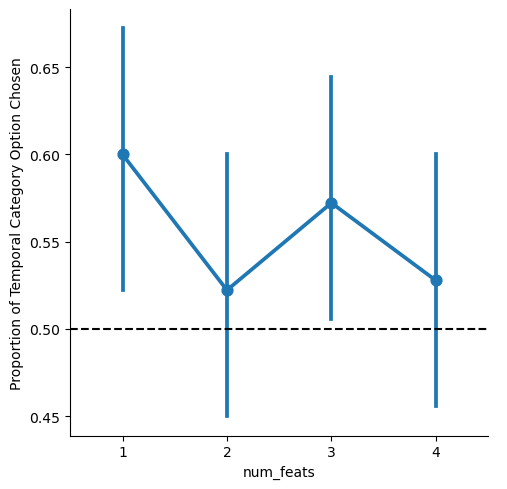

In [46]:
g = sns.catplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean, kind = 'point')
g.axes[0][0].axhline(y = 0.5, ls = '--', color = 'black')
g.axes[0][0].set_ylabel('Proportion of Temporal Category Option Chosen')
